In [130]:
import pickle
import pandas as pd
import matplotlib.pyplot as plt

with open('everything.pkl', 'rb') as file:

    data = pickle.load(file)



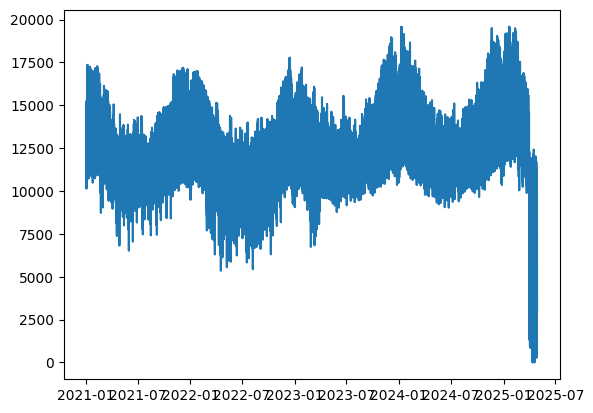

In [131]:
load = data['A16_data']
weer = data['weather_data']

plt.plot(load['timestamp'], load['quantity'])


In [118]:
# Sorteer op timestamp
load = load.sort_values('timestamp')
weer = weer.sort_values('timestamp')

# Merge met nearest match
merged_df = pd.merge_asof(
    load,
    weer,
    on='timestamp',
    direction='nearest'
)

# (Optioneel) terugzetten naar timestamp index
merged_df = merged_df.set_index('timestamp')


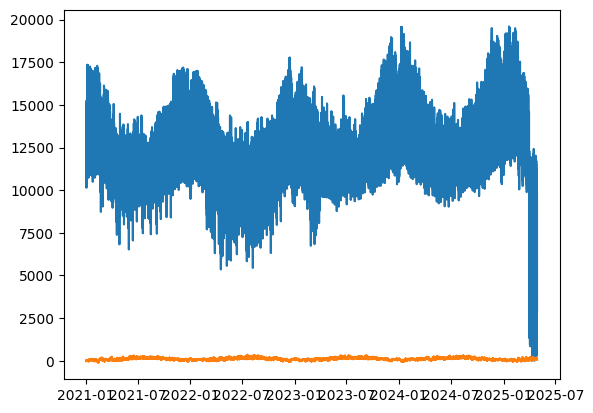

In [119]:
plt.plot(merged_df['quantity'])
plt.plot(merged_df['T'])

In [ ]:
import pandas as pd

# Start met je gemergde table
df = merged_df.copy()

# Maak tijd features
df['hour'] = df.index.hour
df['day_of_week'] = df.index.dayofweek  # maandag = 0, zondag = 6
df['month'] = df.index.month
df['is_weekend'] = df['day_of_week'].isin([5, 6]).astype(int)  # zaterdag/zondag = 1

# Houd alleen de relevante kolommen
model_df = df[['quantity', 'T', 'hour', 'day_of_week', 'month', 'is_weekend']]

# Voeg lagged features toe
model_df['lag_1'] = model_df['quantity'].shift(1)  # 15 min geleden
model_df['lag_2'] = model_df['quantity'].shift(2)  # 30 min geleden
model_df['lag_4'] = model_df['quantity'].shift(4)  # 1 uur geleden

# Voeg rolling averages toe
model_df['rolling_1h'] = model_df['quantity'].rolling(window=4).mean()  # 1 uur
model_df['rolling_2h'] = model_df['quantity'].rolling(window=8).mean()  # 2 uur

import holidays

# Nederlandse feestdagen
nl_holidays = holidays.country_holidays('NL')

# Functie om te checken of een datum een feestdag is
def is_holiday(timestamp):
    return int(timestamp.date() in nl_holidays)

# Voeg feestdag kolom toe
model_df['is_holiday'] = model_df.index.map(is_holiday)
# Bouw nieuwe temperatuur-gerelateerde features
model_df['heating_degree'] = (18 - model_df['T']).clip(lower=0)
model_df['cooling_degree'] = (model_df['T'] - 22).clip(lower=0)


# Drop de rijen met NaNs die door shift/rolling zijn ontstaan
model_df = model_df.dropna()





C:\Users\rkhaz\AppData\Local\Temp\ipykernel_8868\2518631312.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  model_df['lag_1'] = model_df['quantity'].shift(1)  # 15 min geleden
C:\Users\rkhaz\AppData\Local\Temp\ipykernel_8868\2518631312.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  model_df['lag_2'] = model_df['quantity'].shift(2)  # 30 min geleden
C:\Users\rkhaz\AppData\Local\Temp\ipykernel_8868\2518631312.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Da

In [121]:
selected_features = [
    'hour', 'day_of_week', 'month', 'is_weekend', 'is_holiday', 'T',
      'heating_degree', 'cooling_degree'
      
]


X = model_df[selected_features]
y = model_df['quantity']


In [122]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Maak model
model = xgb.XGBRegressor(
    n_estimators=500,
    max_depth=6,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1
)

# Train model
model.fit(X_train, y_train)

# Voorspellen
y_pred = model.predict(X_test)

# Evaluatie
mae = mean_absolute_error(y_test, y_pred)
from sklearn.metrics import root_mean_squared_error

rmse = root_mean_squared_error(y_test, y_pred)


print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")


MAE: 1334.04
RMSE: 1894.41


In [123]:
import xgboost as xgb
import pickle

# Beste model bouwen
best_model = xgb.XGBRegressor(
    subsample=0.9,
    n_estimators=1000,
    min_child_weight=1,
    max_depth=8,
    learning_rate=0.01,
    gamma=0.2,
    colsample_bytree=0.8,
    objective='reg:squarederror',
    n_jobs=-1,
    random_state=42
)

# Trainen op volledige trainingsdata
best_model.fit(X_train, y_train)


# Voorspellen
y_pred = best_model.predict(X_test)

# Evaluatie
mae = mean_absolute_error(y_test, y_pred)
from sklearn.metrics import root_mean_squared_error

rmse = root_mean_squared_error(y_test, y_pred)

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")

# Opslaan als pickle file
with open('best_xgb_model.pkl', 'wb') as f:
    pickle.dump(best_model, f)


MAE: 1332.05
RMSE: 1884.81


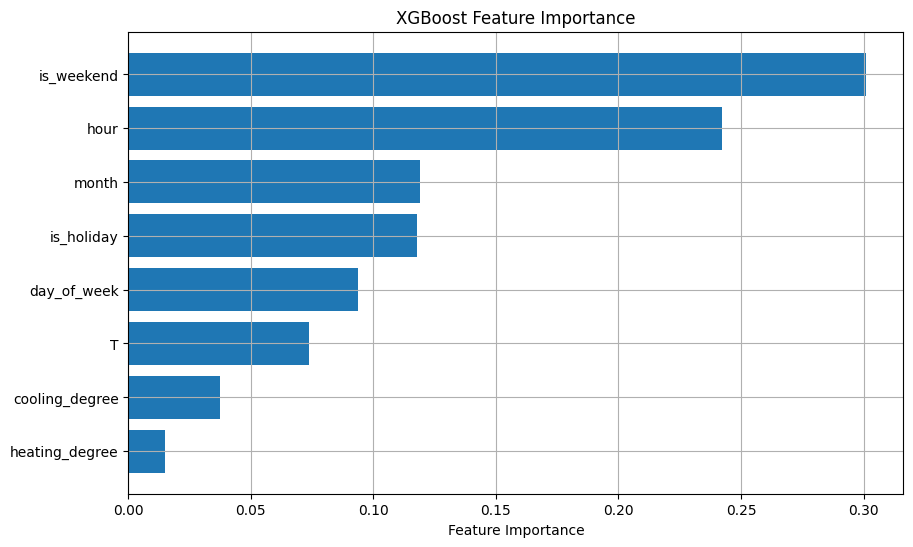

In [124]:
# Plot feature importance
def plot_feature_importance(model, feature_names):
    importances = model.feature_importances_
    indices = importances.argsort()

    plt.figure(figsize=(10,6))
    plt.barh(range(len(indices)), importances[indices], align='center')
    plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
    plt.xlabel('Feature Importance')
    plt.title('XGBoost Feature Importance')
    plt.grid()
    plt.show()

# Gebruik:
plot_feature_importance(model, X.columns)


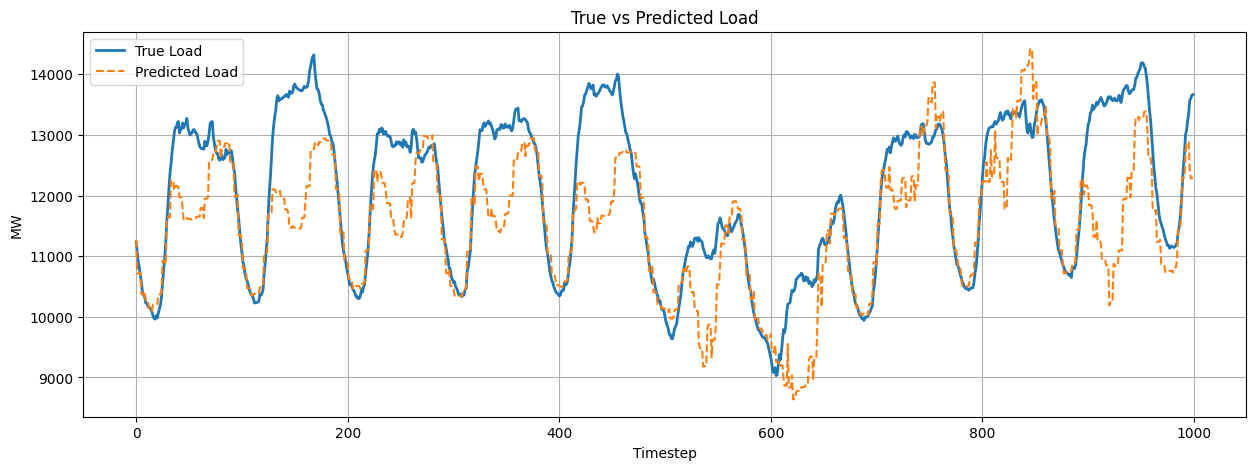

In [125]:
import matplotlib.pyplot as plt

# Functie om voorspellingen vs echte data te plotten
def plot_predictions(y_test, y_pred, start=0, end=500):
    plt.figure(figsize=(15,5))
    plt.plot(y_test.values[start:end], label='True Load', linewidth=2)
    plt.plot(y_pred[start:end], label='Predicted Load', linestyle='--')
    plt.xlabel('Timestep')
    plt.ylabel('MW')
    plt.title('True vs Predicted Load')
    plt.legend()
    plt.grid()
    plt.show()

# Gebruik:
plot_predictions(y_test, y_pred, start=0, end=1000)


In [152]:
import pandas as pd
import pickle

def build_feature_dataframe(raw_df: pd.DataFrame) -> pd.DataFrame:
    """
    Turn the raw weather DataFrame into a feature DataFrame ready for prediction.
    Assumes raw_df.index is a DatetimeIndex and has column 'T' for temperature.
    """


    df = raw_df.copy()

    df['timestamp'] = pd.to_datetime(df['timestamp'])  # Zorg dat timestamp kolom datetime is
    df = df.set_index('timestamp')                     # Zet timestamp als index

    df['hour'] = df.index.hour
    df['day_of_week'] = df.index.dayofweek
    df['month'] = df.index.month
    df['is_weekend'] = df['day_of_week'].isin([5, 6]).astype(int)

    # holiday feature
    import holidays
    nl_holidays = holidays.country_holidays('NL')
    df['is_holiday'] = df.index.to_series().apply(lambda ts: int(ts.date() in nl_holidays))

    # heating / cooling degree
    df['heating_degree'] = (18 - df['T']).clip(lower=0)
    df['cooling_degree'] = (df['T'] - 22).clip(lower=0)

    return df.dropna()

# 1. Model laden
with open('best_xgb_model.pkl', 'rb') as f:
    loaded_model = pickle.load(f)


selected_features = [
    'hour', 'day_of_week', 'month', 'is_weekend', 'is_holiday', 'T',
      'heating_degree', 'cooling_degree'     
]


# Gebruik:
forecast_ready = build_feature_dataframe(weer)

# 2. Features selecteren
X_forecast = forecast_ready[selected_features]

# Voorspellen
y_pred = loaded_model.predict(X_forecast)

pred_df = pd.DataFrame({
        'timestamp': forecast_ready.index,
        'predicted_load': y_pred
    })




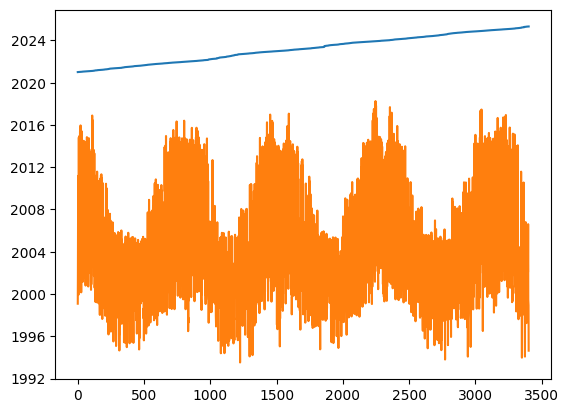

In [153]:
plt.plot(pred_df)

with open('historical_predictions.pkl', 'wb') as file:

    pickle.dump(pred_df, file)